### **Hangman**

### **Hangformer**

#### Few mandatory imports first.

In [1]:
import torch
import random
from tqdm.auto import tqdm

from hangformer import Hangformer
from encode import encode_word_state, decode_word_state, encode_remaining_guesses

/Users/irsh/Documents/workdir/tasks/trexquant/Hangman/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


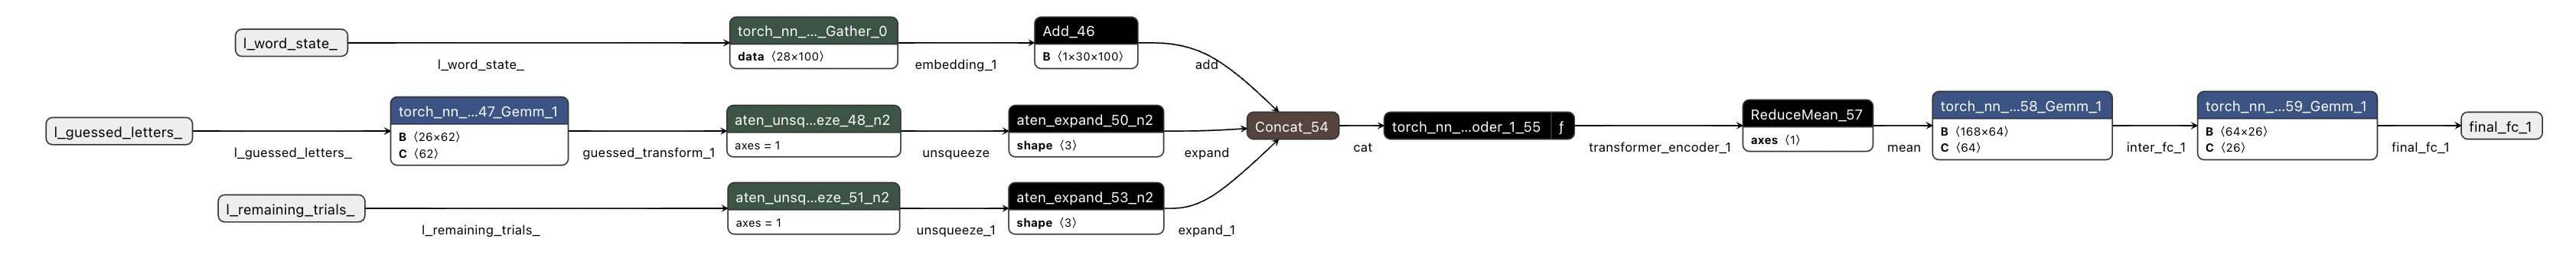

#### How is the game state prepared for the model?
The current board state (incomplete word), previously guessed letters and the remaining guesses are used in the input.

In [2]:
input_board = "solenoid"

# encoder configs
max_length = 30
arr = encode_word_state(input_board, max_length)

print("Tokenized Word State:")
arr

Tokenized Word State:


tensor([[18, 14, 11,  4, 13, 14,  8,  3, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
         27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27]])

In [3]:
decode_word_state(arr[0], remove_special_tokens=True)

'solenoid'

#### Now let's see this in the Hangman task

In [4]:
# How do we tokenize

input_board = "s_len_i_"

# tokenizer configs
max_length = 30
arr = encode_word_state(input_board, max_length)

print("Tokenized Word State:")
arr

Tokenized Word State:


tensor([[18, 26, 11,  4, 13, 26,  8, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
         27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27]])

In [5]:
decode_word_state(arr[0], remove_special_tokens=True)

's[MASK]len[MASK]i[MASK]'

#### Previously Guessed Letters
These are encoded in one-hot format. (a 26 long vector)

In [6]:
guessed_list = ['s', 'l', 'e', 'n', 'i']

def encode_guessed_characters(guessed):
    op = [0]*26
    for guess in guessed:
        op[ord(guess) - ord('a')] = 1
    return op

guessed = encode_guessed_characters(guessed_list)
print("Encoded Guessed Characters List:")
guessed

Encoded Guessed Characters List:


[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [7]:
total_guesses = 6
incorrect_guesses = 1

rem_guesses = encode_remaining_guesses(total_guesses - incorrect_guesses)

print("Encoded Remaining Guesses:")
rem_guesses

Encoded Remaining Guesses:


[0, 1, 0, 0, 0, 0]

#### Loading in the Model
Hangformer model is a 2.43M Encoder only Transformer architecture

In [8]:
model = torch.load("../models/episode_8000.pth", map_location="cpu", weights_only=False)
model.eval()

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 2430732


In [9]:
model_op = model(
    torch.tensor(arr), 
    torch.tensor(guessed).float().unsqueeze(0), 
    torch.tensor(rem_guesses).float().unsqueeze(0)
    )

model_op

/var/folders/02/1lkcymwj2ws1mlc4pyg16vqr0000gn/T/ipykernel_87929/566580278.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(arr),


tensor([[  0.4494,  -3.0903,   0.0331,   1.0258, -11.9530,  -3.9620,  -2.1564,
          -2.3067, -10.5596,  -7.2489,  -3.8483,  -6.7592,  -3.1176,  -8.0073,
          -0.4540,  -0.9810,  -6.6880,  -2.7242,  -8.6205,  -0.6956,  -2.8173,
          -3.4781,  -5.3165,  -4.6101,  -3.0483,  -5.0844]],
       grad_fn=<AddmmBackward0>)

In [10]:
letter = chr(ord('a') + torch.argmax(model_op.squeeze()).item())
letter

'd'

#### Let's visualize the model outputs:
The outputs can be passed through softmax to visualize them as action probabilities

/var/folders/02/1lkcymwj2ws1mlc4pyg16vqr0000gn/T/ipykernel_87929/3490489653.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(model_op.squeeze())


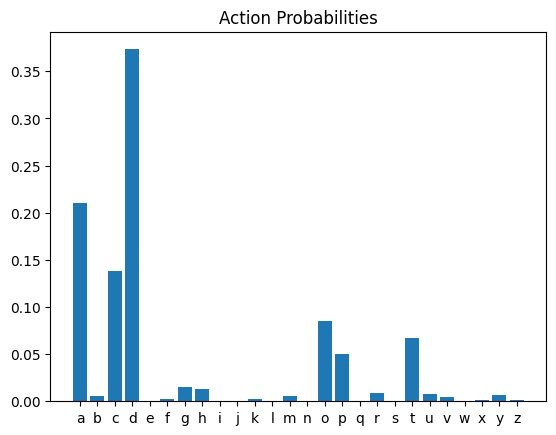

In [11]:
import matplotlib.pyplot as plt

with torch.no_grad():
    probs = torch.nn.functional.softmax(model_op.squeeze())
    plt.bar(range(26), probs)
    plt.xticks(range(26), [chr(ord('a') + i) for i in range(26)])
    plt.title("Action Probabilities")

#### Training Strategy
For training, BCEWithLogitsLoss was used to 'match' the output probabilities to a uniform distribution of the unguessed letters:

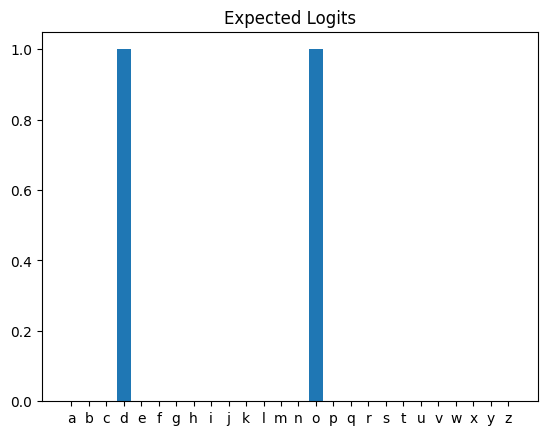

In [12]:
actual_word = "solenoid"
curr_state = "s_len_i_"
unguessed = set(actual_word) - set(curr_state)

hts = [0]*26
for i in range(26):
    if chr(i + ord('a')) in unguessed:
        hts[i] = 1  # Not converting to probs since loss already has sigmoid

plt.bar(range(26), hts)
plt.xticks(range(26), [chr(ord('a') + i) for i in range(26)])
plt.title("Expected Logits")
plt.show()

In [13]:
criterion = torch.nn.BCEWithLogitsLoss()

criterion(model_op.squeeze(), torch.tensor(hts).float())

tensor(0.1609, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

### Non-ML Approach:

Max Length is 29


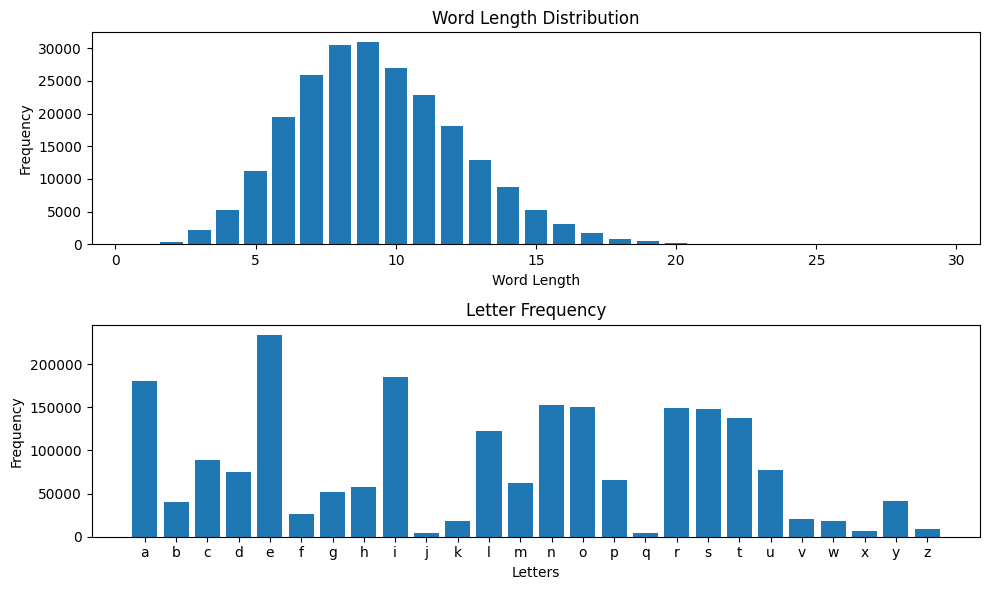

In [15]:
import collections
import re
import string
from nltk import ngrams

with open('data/words_250000_train.txt', 'r') as file:
    words = file.read().split()

word_lengths = [len(word) for word in words]
length_counts = collections.Counter(word_lengths)
print(f"Max Length is {max(word_lengths)}")
all_letters = ''.join(words)
letter_counts = collections.Counter(all_letters)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

ax1.bar(length_counts.keys(), length_counts.values())
ax1.set_xlabel('Word Length')
ax1.set_ylabel('Frequency')
ax1.set_title('Word Length Distribution')

letters = sorted(letter_counts.keys())
frequencies = [letter_counts[letter] for letter in letters]
ax2.bar(letters, frequencies)
ax2.set_xlabel('Letters')
ax2.set_ylabel('Frequency')
ax2.set_title('Letter Frequency')

plt.tight_layout()
plt.show()

#### Checking N-Grams

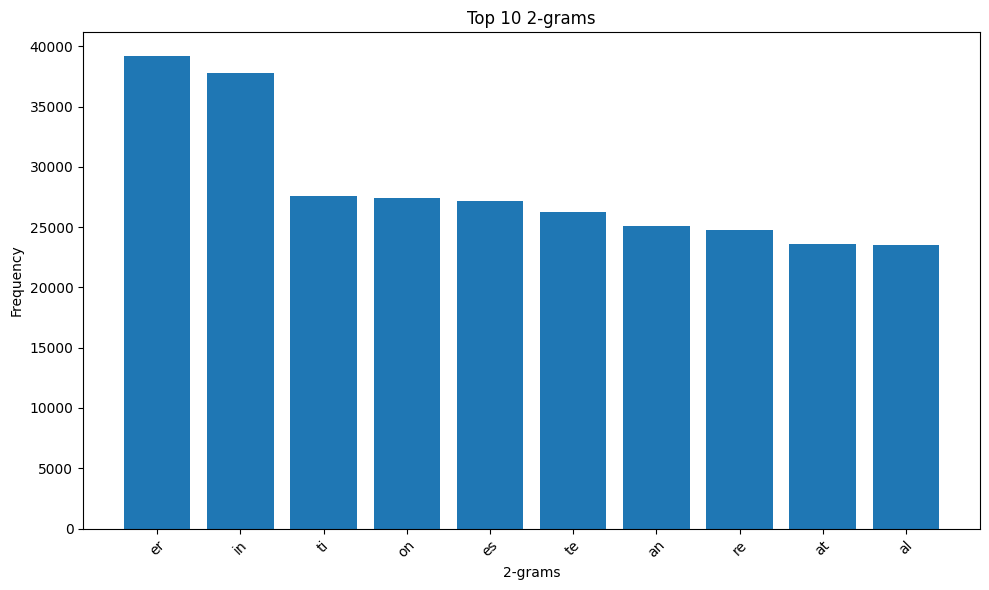

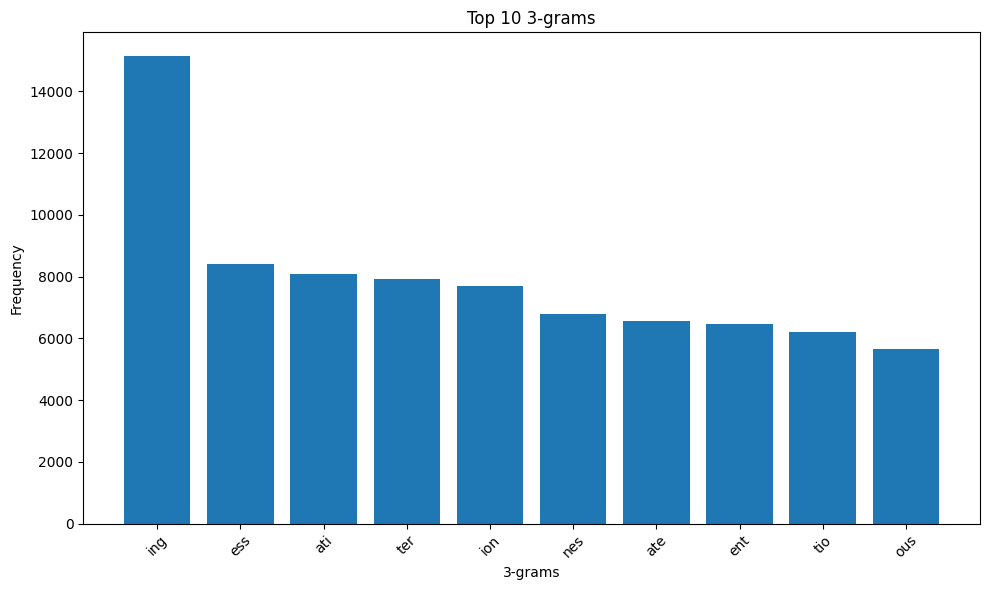

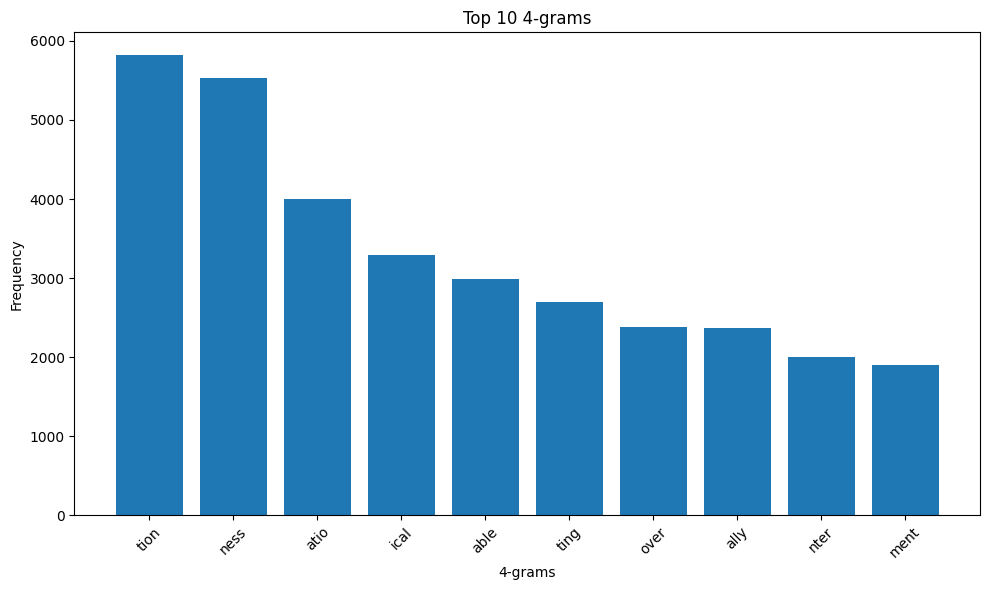

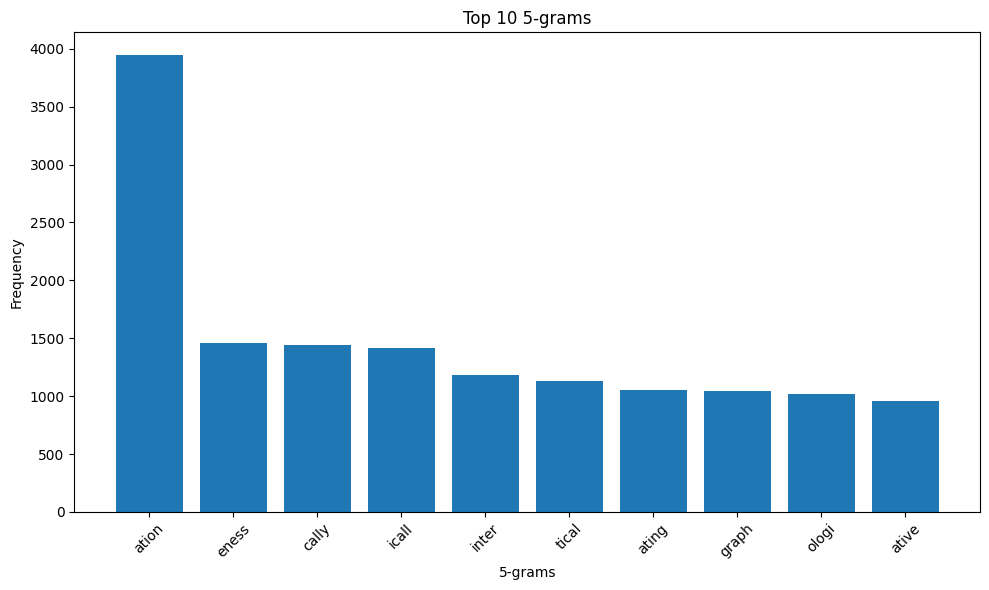

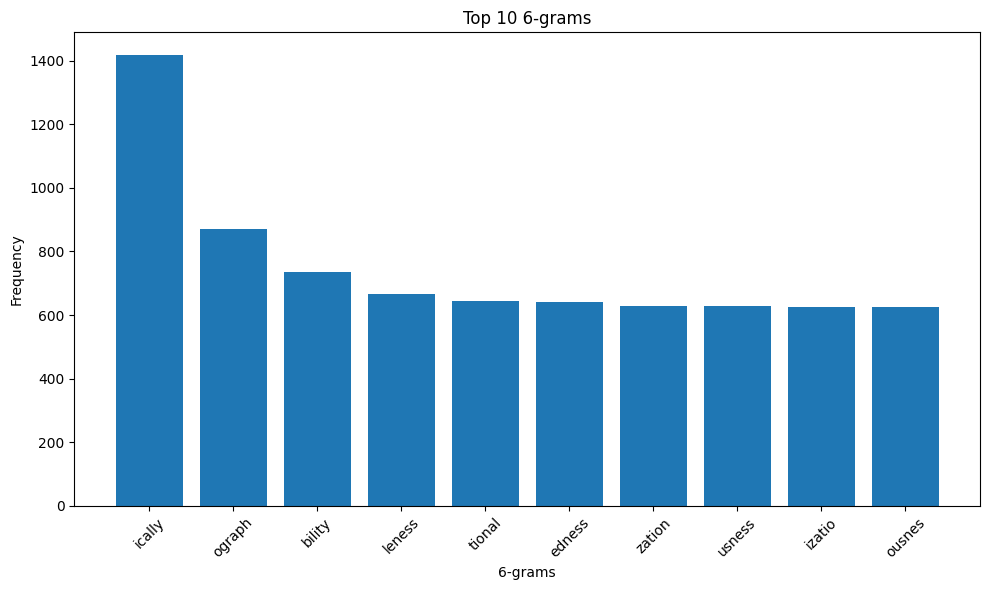

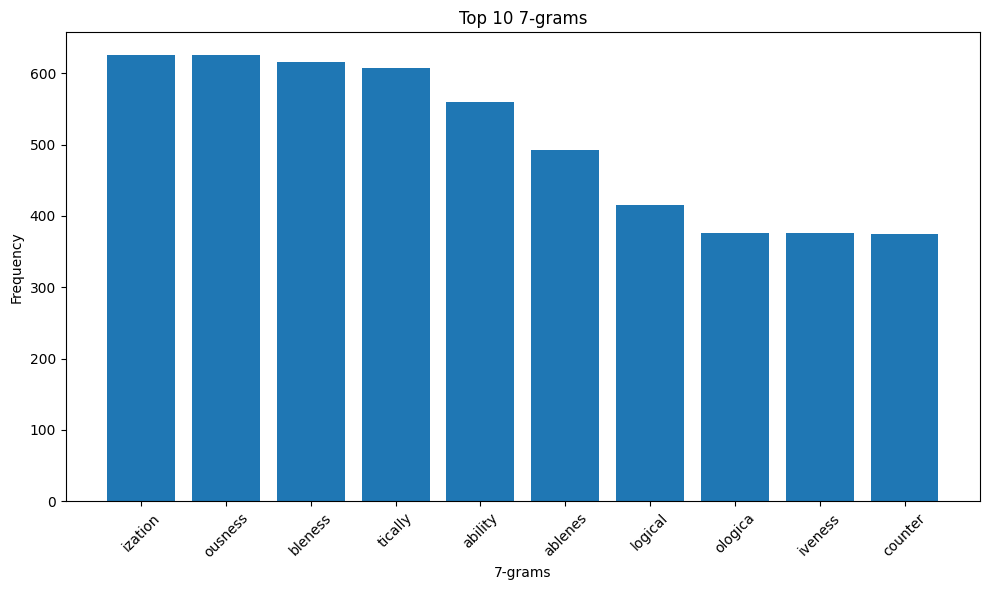

In [16]:
def plot_top_ngrams(word_list, n, top_k=10):
    n_grams = [ngram for word in word_list for ngram in ngrams(word, n)]
    ngram_freq = collections.Counter(n_grams)
    
    top_ngrams = ngram_freq.most_common(top_k)
    ngrams_labels, ngram_counts = zip(*top_ngrams)
    
    ngrams_labels = [''.join(gram) for gram in ngrams_labels]
    
    plt.figure(figsize=(10,6))
    plt.bar(ngrams_labels, ngram_counts)
    plt.title(f'Top {top_k} {n}-grams')
    plt.xlabel(f'{n}-grams')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

word_list = open('data/words_250000_train.txt').read().split() 

plot_top_ngrams(word_list, 2)
plot_top_ngrams(word_list, 3)
plot_top_ngrams(word_list, 4)
plot_top_ngrams(word_list, 5)
plot_top_ngrams(word_list, 6)
plot_top_ngrams(word_list, 7)

#### Creating Frequency Lists for N-grams

In [17]:
def create_freq_lists(dictionary, n):
        suf_freq = {}
        n_seq_freq = {}
        pre_freq = {}
        
        for words in dictionary:
            if (len(words) < n):
                continue
                
            for i in range(len(words)-n+1):
                if (words[i:i+n] not in n_seq_freq.keys()):
                    n_seq_freq[words[i:i+n]] = 0
                n_seq_freq[words[i:i+n]] += 1
        
            if (words[0:0+n] not in pre_freq.keys()):
                pre_freq[words[0:0+n]] = 0
            pre_freq[words[0:0+n]] += 1
                            
            if (words[-n:] not in suf_freq.keys()):
                suf_freq[words[-n:]] = 0
            suf_freq[words[-n:]] += 1
            
        return n_seq_freq, pre_freq, suf_freq

def prepare_heuristics(full_dictionary):
    current_dictionary = []
    nseq_freq_list = []
    prefix_freq_list = []
    suffix_freq_list = []

    max_sequence_length = 7
    for i in range(max_sequence_length):
        temp1, temp2, temp3 = create_freq_lists(full_dictionary, i+1)
        nseq_freq_list.append(temp1)
        prefix_freq_list.append(temp2)
        suffix_freq_list.append(temp3)  
    
    return current_dictionary, max_sequence_length, nseq_freq_list, prefix_freq_list, suffix_freq_list

Taking a toy example of `dinosaurs.txt`

In [18]:
# toy example
full_dictionary = open("data/dinosaurs.txt").read().split()
print("Examples: ", random.sample(full_dictionary, 3))

current_dictionary, max_sequence_length, nseq_freq_list, prefix_freq_list, suffix_freq_list = prepare_heuristics(full_dictionary)

Examples:  ['parasaurolophus', 'anhuilong', 'archaeornis']


We expect that the most-frequent n-gram of length 4 should be `saur`

In [19]:
size = 4
print(f"Most frequent n-gram of length {size}: {sorted(nseq_freq_list[size-1].items(), key=lambda x: -x[1])[0]}")
print(f"Most frequent prefix of length {size}: {sorted(prefix_freq_list[size-1].items(), key=lambda x: -x[1])[0]}")
print(f"Most frequent suffix of length {size}: {sorted(suffix_freq_list[size-1].items(), key=lambda x: -x[1])[0]}")

Most frequent n-gram of length 4: ('saur', 708)
Most frequent prefix of length 4: ('sino', 11)
Most frequent suffix of length 4: ('urus', 681)


Since this works, let's move onto our `words_250000_train.txt`

In [20]:
full_dictionary = open("data/words_250000_train.txt").read().split()
current_dictionary, max_sequence_length, nseq_freq_list, prefix_freq_list, suffix_freq_list = prepare_heuristics(full_dictionary)

In [21]:
size = 5
print(f"Most frequent n-gram of length {size}: {sorted(nseq_freq_list[size-1].items(), key=lambda x: -x[1])[0]}")
print(f"Most frequent prefix of length {size}: {sorted(prefix_freq_list[size-1].items(), key=lambda x: -x[1])[0]}")
print(f"Most frequent suffix of length {size}: {sorted(suffix_freq_list[size-1].items(), key=lambda x: -x[1])[0]}")

Most frequent n-gram of length 5: ('ation', 3945)
Most frequent prefix of length 5: ('inter', 942)
Most frequent suffix of length 5: ('ation', 2908)


Note the discrepancy in `ation` being an n-gram more frequently than a suffix is due to words like `internationally`.

We also merge these sequence lists with a weight given to prefix and suffixes since they are counted twice in n-grams as well.

In [22]:
def merge_dict_lists(nseq_freq_list, prefix_freq_list, suffix_freq_list, presuf_weight = 1.0):
    result = []

    for i in range(len(nseq_freq_list)):
        temp = collections.Counter(prefix_freq_list[i]) + collections.Counter(suffix_freq_list[i])
        for k in temp.keys():
            temp[k] = temp[k] * presuf_weight
            
        temp = dict(collections.Counter(nseq_freq_list[i]) + temp)
        result.append(temp)
        
    return result

In [23]:
freq_list = merge_dict_lists(nseq_freq_list, prefix_freq_list, suffix_freq_list, presuf_weight=1.0)

In [24]:
print(f"Most frequent seqfreq of length {size}: {sorted(freq_list[size-1].items(), key=lambda x: -x[1])[0]}")

Most frequent seqfreq of length 5: ('ation', 6854.0)


In [25]:
def guess_heuristic(clean_word, guessed_letters, full_dictionary, freq_list, verbose=False, max_sequence_length=7):
    # for regex
    clean_word = clean_word.replace("_", ".")

    guessed_but_not_found_letters = set()
    for let in guessed_letters:
        if let not in clean_word:
            guessed_but_not_found_letters.add(let)
    
    if verbose:
        print("Guessed but not found: ", guessed_but_not_found_letters)
    
    len_word = len(clean_word)        
    
    vowels = "aeiou"
    num_vowels = sum(1 for char in clean_word if char in vowels)
    num_consonants = len(clean_word) - num_vowels
    
    current_dictionary = full_dictionary
    new_dictionary = []
    
    # exact regex matching
    for dict_word in current_dictionary:
        if len(dict_word) != len_word:
            continue
        else: 
            if re.match(clean_word,dict_word):
                add = True

                temp = list(guessed_but_not_found_letters)
                for char in temp:
                    if char in dict_word:
                        add = False
                        break
                
                if (add == True):
                    new_dictionary.append(dict_word)

    if verbose:
        print("Size of dictionary after exact matching: ", len(new_dictionary))
    
    freq_table_lat = {}
    for alphabet in list(string.ascii_lowercase):
        freq_table_lat[alphabet] = 0
    
    # weights: 1, 10, 100, 1000, 10000, 100000, 1000000
    n_seq_weights  = [10**i for i in range(max_sequence_length)]

    # iterating through ns of n-gram
    for i in range(max_sequence_length):
        temp = freq_list[i]
        # iterating through n-grams
        for ngram, freq in sorted(temp.items(), key=lambda x: (x[1], x[0]), reverse=True):
            curr = list(ngram)
            guess_letters = []
            skip = False
            # iterating through letters in that n-gram 
            for pos in range(i+1):
                if curr[pos] in guessed_but_not_found_letters:
                    # skipping n-gram if it contains useless letters
                    skip = True
                    break
                elif curr[pos] not in guessed_letters:
                    guess_letters.append(curr[pos])
                    curr[pos] = '!'
            
            temp_string = clean_word.replace('.', '!')
            curr = "".join(curr) # n-gram with replaced '!' if chosen

            if (skip == False and len(guess_letters)!=0):
                # checking for n-gram pattern match in our word
                if (re.search(curr, temp_string)):
                    itr = re.finditer(curr, temp_string)
                    for match in itr:
                        for guess in guess_letters:
                            # adding freq * n-gram length weight
                            freq_table_lat[guess] += (n_seq_weights[i]*freq)
                    break
    
    if num_vowels > 1.5 * num_consonants:
        for vowel in vowels:
            if vowel not in guessed_letters:
                freq_table_lat[vowel] *= 0.1
    
    if verbose:
        print("Frequency table top 3: ", sorted(freq_table_lat.items(), key=lambda x: (x[1], x[0]), reverse=True)[:3])
    
    for letter, freq in sorted(freq_table_lat.items(), key=lambda x: (x[1], x[0]), reverse=True):
        if letter not in guessed_letters and freq != 0:
            return letter
    

    # fallback to new dictionary
    for letter, _ in collections.Counter("".join(new_dictionary)).most_common():
        if letter not in guessed_letters:
                return letter


In [26]:
guess_heuristic("a__le", ['a', 'e', 'l', 'n', 'd', 't'], full_dictionary, freq_list, verbose=True)

Guessed but not found:  {'t', 'd', 'n'}
Size of dictionary after exact matching:  6
Frequency table top 3:  [('p', 1800000.0), ('b', 1639000.0), ('i', 1171410.0)]


'p'

In [27]:
guess_heuristic("s_len_i_", ['s', 'l', 'e', 'n', 'i'], full_dictionary, freq_list, verbose=True)

Guessed but not found:  set()
Size of dictionary after exact matching:  2
Frequency table top 3:  [('d', 18700000.0), ('o', 14000000.0), ('g', 14000000.0)]


'd'

In [28]:
def guess_hangformer(model, device, max_length, word_state, guessed, remaining_guesses):
    encoded_state = encode_word_state(word_state, max_length).to(device)
    guessed_tensor = torch.tensor(guessed).float().unsqueeze(0).to(device)
    remaining_guesses_encoded = encode_remaining_guesses(remaining_guesses)
    remaining_guesses_tensor = torch.tensor(remaining_guesses_encoded).float().unsqueeze(0).to(device)
    
    with torch.no_grad():
        action_probs = model(encoded_state, guessed_tensor, remaining_guesses_tensor).squeeze()
    
    for idx, pos in enumerate(guessed):
        if pos:
            action_probs[idx] = - float("inf")
        
    action = torch.argmax(action_probs).item()
    letter = chr(action + ord('a'))
    return letter

In [34]:
class HangmanPlayer:
    def __init__(self, device="mps", mode="oh") -> None:
        self.mode = mode
        self.device = device
        self.guessed_letters = []
        self.model = torch.load("../models/episode_8000.pth", map_location=self.device, weights_only=False)
        self.model.eval()
        self.open_model = torch.load("../models/open_100.pth", map_location=self.device, weights_only=False)
        self.open_model.eval()
        self.close_model = torch.load("../models/close_400.pth", map_location=self.device, weights_only=False)
        self.close_model.eval()
        self.tries_remains = 6
        self.close_threshold = 3

    def guess_one(self, clean_word):
        device = self.device
        eg = [0]*26
        for g in self.guessed_letters:
            eg[ord(g)-ord('a')] = 1

        if self.mode == "oc":
            if clean_word.count("_") >= len(clean_word) // 2:
                letter = guess_hangformer(self.open_model, device, max_length, clean_word, eg, remaining_guesses=self.tries_remains)
            else:
                letter = guess_hangformer(self.close_model, device, max_length, clean_word, eg, remaining_guesses=self.tries_remains)
        elif self.mode == "obc":
            if clean_word.count("_") >= len(clean_word) // 3:
                letter = guess_hangformer(self.open_model, device, max_length, clean_word, eg, remaining_guesses=self.tries_remains)
            elif clean_word.count("_") >= 2 * len(clean_word) // 3:
                letter = guess_hangformer(self.model, device, max_length, clean_word, eg, remaining_guesses=self.tries_remains)
            else:
                letter = guess_hangformer(self.close_model, device, max_length, clean_word, eg, remaining_guesses=self.tries_remains)
        elif self.mode == "h":
            letter = guess_heuristic(clean_word, self.guessed_letters, open("data/words_250000_train.txt").read().split(), freq_list)
        elif self.mode == "hc":
            if clean_word.count("_") >= len(clean_word) // 2:
                letter = guess_heuristic(clean_word, self.guessed_letters, open("data/words_250000_train.txt").read().split(), freq_list)
            else:
                letter = guess_hangformer(self.close_model, device, max_length, clean_word, eg, remaining_guesses=self.tries_remains)
        elif self.mode == "oh":
            if clean_word.count("_") >= self.close_threshold:
                letter = guess_hangformer(self.open_model, device, max_length, clean_word, eg, remaining_guesses=self.tries_remains)
            else:
                letter = guess_heuristic(clean_word, self.guessed_letters, open("data/words_250000_train.txt").read().split(), freq_list)
        else:
            letter = guess_hangformer(self.model, device, max_length, clean_word, eg, remaining_guesses=self.tries_remains)

        self.guessed_letters.append(letter)
        return letter
    
    def play(self, word, verbose=False):
        self.guessed_letters = []
        slate = ["_"] * len(word)
        done = False
        while not done:
            guess = self.guess_one("".join(slate))

            if guess in word:
                for i, letter in enumerate(word):
                    if letter == guess:
                        slate[i] = guess
            else:
                self.tries_remains -= 1
            
            if verbose:
                print("Word: ", "".join(slate), " | Guess: ", guess, " | Remaining: ", self.tries_remains)
            done = (self.tries_remains == 0 or slate.count("_") == 0)
        
        self.tries_remains = 6
        return (self.tries_remains > 0 and slate.count("_") == 0)

In [35]:
hp = HangmanPlayer(mode="oh")
hp.play("solenoid", verbose=True)

Word:  ___e____  | Guess:  e  | Remaining:  6
Word:  ___e____  | Guess:  a  | Remaining:  5
Word:  ___e__i_  | Guess:  i  | Remaining:  5
Word:  _o_e_oi_  | Guess:  o  | Remaining:  5
Word:  _o_e_oid  | Guess:  d  | Remaining:  5
Word:  _o_e_oid  | Guess:  r  | Remaining:  4
Word:  _o_enoid  | Guess:  n  | Remaining:  4
Word:  so_enoid  | Guess:  s  | Remaining:  4
Word:  solenoid  | Guess:  l  | Remaining:  4


True

### Model Selection

In [ ]:
all_words = set(open("data/all_english_words.txt", "r").read().split())
tq_words = set(open("data/words_250000_train.txt", "r").read().split())
unseen = list(all_words - tq_words)

num_iters = 10
num_words = 10

results = {}

for i in range(num_iters):
    words = random.sample(unseen, num_words)
    print(words)
    for mode in tqdm(["oc", "hc", "oh", "b", "h"]):
        hp.mode = mode
        hits = sum(map(lambda x: hp.play(x, False), words))
        if mode not in results:
            results[mode] = []
        results[mode].append(hits/num_words)
    print(results)

['sloe', 'requitement', 'kyschty', 'kassite', 'noncombustibles', 'modulator', 'waterside', 'overemptiness', 'nonvaccination', 'quarterstaff']


100%|██████████| 5/5 [02:55<00:00, 35.14s/it]


{'oc': [0.6], 'hc': [0.5], 'oh': [0.8], 'b': [0.6], 'h': [0.7]}
['autodidactically', 'sulphoamid', 'abel', 'fortuneteller', 'bemba', 'peching', 'pennoncelle', 'onomatopoesis', 'glebae', 'flimflam']


100%|██████████| 5/5 [03:05<00:00, 37.04s/it]


{'oc': [0.6, 0.4], 'hc': [0.5, 0.6], 'oh': [0.8, 0.4], 'b': [0.6, 0.4], 'h': [0.7, 0.4]}
['colunar', 'polysemant', 'chresards', 'sunbathing', 'sexfarious', 'antimonarchal', 'toilinet', 'unsuspective', 'monospermy', 'suegee']


100%|██████████| 5/5 [03:13<00:00, 38.61s/it]


{'oc': [0.6, 0.4, 0.8], 'hc': [0.5, 0.6, 0.5], 'oh': [0.8, 0.4, 0.7], 'b': [0.6, 0.4, 0.8], 'h': [0.7, 0.4, 0.6]}
['dilatably', 'redissolve', 'fullbacks', 'shoddiest', 'saices', 'erbium', 'yoghourt', 'poplinette', 'sulphocyanic', 'promiseless']


100%|██████████| 5/5 [02:36<00:00, 31.24s/it]


{'oc': [0.6, 0.4, 0.8, 0.5], 'hc': [0.5, 0.6, 0.5, 0.5], 'oh': [0.8, 0.4, 0.7, 0.4], 'b': [0.6, 0.4, 0.8, 0.5], 'h': [0.7, 0.4, 0.6, 0.6]}
['suprapubic', 'dramatists', 'rachilla', 'supercoincident', 'apocarpy', 'vasoformative', 'semostomous', 'ombrophilic', 'crossosomataceous', 'borstall']


100%|██████████| 5/5 [02:59<00:00, 35.90s/it]


{'oc': [0.6, 0.4, 0.8, 0.5, 0.9], 'hc': [0.5, 0.6, 0.5, 0.5, 0.8], 'oh': [0.8, 0.4, 0.7, 0.4, 0.8], 'b': [0.6, 0.4, 0.8, 0.5, 0.9], 'h': [0.7, 0.4, 0.6, 0.6, 0.9]}
['dreamsily', 'triphane', 'abeam', 'calcaneoplantar', 'hypertrophied', 'inconnexion', 'henchmanship', 'neighed', 'oxyl', 'circination']


100%|██████████| 5/5 [03:09<00:00, 37.86s/it]


{'oc': [0.6, 0.4, 0.8, 0.5, 0.9, 0.7], 'hc': [0.5, 0.6, 0.5, 0.5, 0.8, 0.7], 'oh': [0.8, 0.4, 0.7, 0.4, 0.8, 0.7], 'b': [0.6, 0.4, 0.8, 0.5, 0.9, 0.6], 'h': [0.7, 0.4, 0.6, 0.6, 0.9, 0.7]}
['demikindred', 'tribute', 'gladiolar', 'wattages', 'cathine', 'bretwalda', 'flaxlike', 'golee', 'irrepair', 'unfatuitously']


100%|██████████| 5/5 [03:07<00:00, 37.45s/it]


{'oc': [0.6, 0.4, 0.8, 0.5, 0.9, 0.7, 0.6], 'hc': [0.5, 0.6, 0.5, 0.5, 0.8, 0.7, 0.4], 'oh': [0.8, 0.4, 0.7, 0.4, 0.8, 0.7, 0.8], 'b': [0.6, 0.4, 0.8, 0.5, 0.9, 0.6, 0.5], 'h': [0.7, 0.4, 0.6, 0.6, 0.9, 0.7, 0.6]}
['roundishness', 'stationeries', 'banger', 'uninterestingly', 'gleemaiden', 'motioner', 'rhema', 'arcticwards', 'maistres', 'twangier']


100%|██████████| 5/5 [03:19<00:00, 39.96s/it]


{'oc': [0.6, 0.4, 0.8, 0.5, 0.9, 0.7, 0.6, 0.9], 'hc': [0.5, 0.6, 0.5, 0.5, 0.8, 0.7, 0.4, 0.5], 'oh': [0.8, 0.4, 0.7, 0.4, 0.8, 0.7, 0.8, 0.8], 'b': [0.6, 0.4, 0.8, 0.5, 0.9, 0.6, 0.5, 0.9], 'h': [0.7, 0.4, 0.6, 0.6, 0.9, 0.7, 0.6, 0.6]}
['simonism', 'slibbersauce', 'uppermore', 'vesiculitis', 'cockaleekie', 'divestiture', 'rebec', 'bourgeoisitic', 'accentuality', 'nonsyncopation']


100%|██████████| 5/5 [02:56<00:00, 35.38s/it]


{'oc': [0.6, 0.4, 0.8, 0.5, 0.9, 0.7, 0.6, 0.9, 0.7], 'hc': [0.5, 0.6, 0.5, 0.5, 0.8, 0.7, 0.4, 0.5, 0.8], 'oh': [0.8, 0.4, 0.7, 0.4, 0.8, 0.7, 0.8, 0.8, 0.7], 'b': [0.6, 0.4, 0.8, 0.5, 0.9, 0.6, 0.5, 0.9, 0.7], 'h': [0.7, 0.4, 0.6, 0.6, 0.9, 0.7, 0.6, 0.6, 0.5]}
['arteriomotor', 'vinewise', 'internecion', 'dynamitism', 'antiacid', 'jezebelian', 'mistle', 'bunnia', 'shinneys', 'flemished']


100%|██████████| 5/5 [03:11<00:00, 38.27s/it]

{'oc': [0.6, 0.4, 0.8, 0.5, 0.9, 0.7, 0.6, 0.9, 0.7, 0.7], 'hc': [0.5, 0.6, 0.5, 0.5, 0.8, 0.7, 0.4, 0.5, 0.8, 0.3], 'oh': [0.8, 0.4, 0.7, 0.4, 0.8, 0.7, 0.8, 0.8, 0.7, 0.6], 'b': [0.6, 0.4, 0.8, 0.5, 0.9, 0.6, 0.5, 0.9, 0.7, 0.6], 'h': [0.7, 0.4, 0.6, 0.6, 0.9, 0.7, 0.6, 0.6, 0.5, 0.6]}


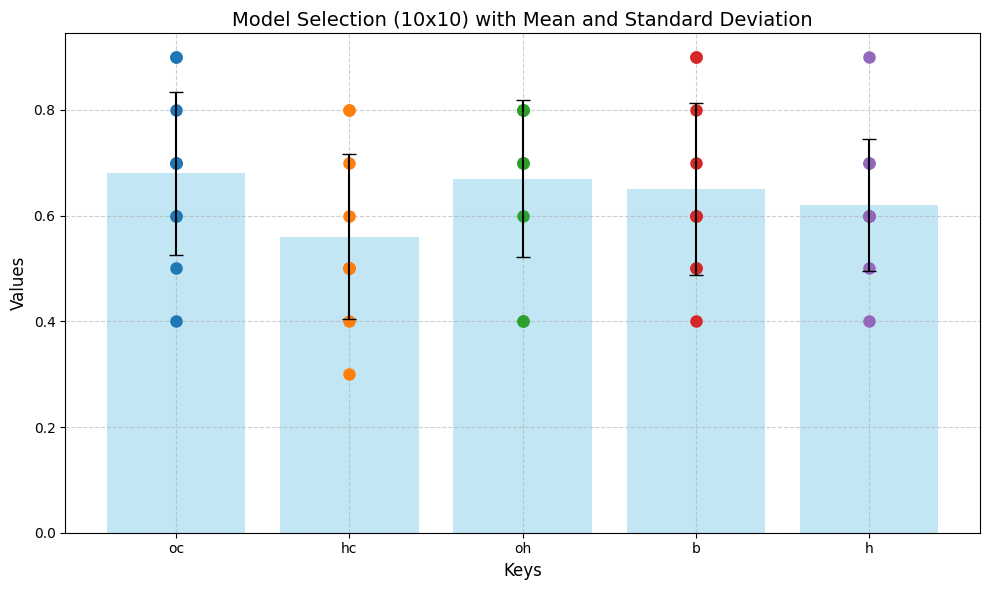

Model Metrics:
oc - Mean: 0.68, Std Dev: 0.1536, 95%: 0.37
oh - Mean: 0.67, Std Dev: 0.1487, 95%: 0.37
b - Mean: 0.65, Std Dev: 0.1628, 95%: 0.32
h - Mean: 0.62, Std Dev: 0.1249, 95%: 0.37
hc - Mean: 0.56, Std Dev: 0.1562, 95%: 0.25


In [30]:
import numpy as np

results = {'oc': [0.6, 0.4, 0.8, 0.5, 0.9, 0.7, 0.6, 0.9, 0.7, 0.7], 'hc': [0.5, 0.6, 0.5, 0.5, 0.8, 0.7, 0.4, 0.5, 0.8, 0.3], 'oh': [0.8, 0.4, 0.7, 0.4, 0.8, 0.7, 0.8, 0.8, 0.7, 0.6], 'b': [0.6, 0.4, 0.8, 0.5, 0.9, 0.6, 0.5, 0.9, 0.7, 0.6], 'h': [0.7, 0.4, 0.6, 0.6, 0.9, 0.7, 0.6, 0.6, 0.5, 0.6]}

fig, ax = plt.subplots(figsize=(10, 6))

keys = list(results.keys())
means = [np.mean(results[key]) for key in keys]
std_devs = [np.std(results[key]) for key in keys]

for key in keys:
    ax.plot([key] * len(results[key]), results[key], 'o', label=f'{key} values', markersize=8)

ax.bar(keys, means, yerr=std_devs, capsize=5, color='skyblue', alpha=0.5, label='Mean with Std Dev')

ax.set_xlabel('Keys', fontsize=12)
ax.set_ylabel('Values', fontsize=12)
ax.set_title('Model Selection (10x10) with Mean and Standard Deviation', fontsize=14)

ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

# Display metrics
print("Model Metrics:")

metrics = {k:(means[i], std_devs[i]) for i, k in enumerate(results.keys())}
metrics = dict(sorted(metrics.items(), key=lambda x: (-x[1][0], x[1][1])))

for model, (mean_val, std) in metrics.items():
    print(f"{model} - Mean: {mean_val:.2f}, Std Dev: {std:.4f}, 95%: {mean_val - 2 * std:.2f}")

In [69]:
all_words = set(open("all_english_words.txt", "r").read().split())
tq_words = set(open("words_250000_train.txt", "r").read().split())
unseen = list(all_words - tq_words)

num_iters = 10
num_words = 10

results = [[] for _ in range(7)]
hp.mode = "oh"

for i in range(num_iters):
    words = random.sample(unseen, num_words)
    print(words)
    for thres in tqdm(range(7)):
        hp.close_threshold = thres + 1
        hits = sum(map(lambda x: hp.play(x, False), words))
        results[thres].append(hits/num_words)
    print(results)

['dentical', 'pigmenting', 'squirters', 'sacrodynia', 'shipside', 'macropsy', 'kashan', 'dangering', 'nonabortively', 'fruits']


100%|██████████| 7/7 [03:01<00:00, 25.88s/it]


[[0.8], [0.9], [0.9], [0.9], [0.9], [0.9], [0.9]]
['unadapted', 'doiled', 'potful', 'enfranchisements', 'trichinoses', 'obtruder', 'respectiveness', 'hydnaceae', 'guarded', 'stenosis']


100%|██████████| 7/7 [02:41<00:00, 23.02s/it]


[[0.8, 0.9], [0.9, 0.9], [0.9, 0.9], [0.9, 0.9], [0.9, 0.9], [0.9, 0.9], [0.9, 0.9]]
['pigweed', 'filtre', 'vitrite', 'rereward', 'unbrazenly', 'prussianise', 'meanings', 'favorers', 'hemochromatosis', 'scowther']


100%|██████████| 7/7 [03:24<00:00, 29.21s/it]


[[0.8, 0.9, 0.7], [0.9, 0.9, 0.7], [0.9, 0.9, 0.7], [0.9, 0.9, 0.7], [0.9, 0.9, 0.7], [0.9, 0.9, 0.7], [0.9, 0.9, 0.7]]
['ascriptitius', 'reversionist', 'focusers', 'cordonnet', 'orthohydrogen', 'cranioscopy', 'pithecanthropi', 'nonfluctuating', 'terraculture', 'solmizate']


100%|██████████| 7/7 [02:30<00:00, 21.56s/it]


[[0.8, 0.9, 0.7, 0.8], [0.9, 0.9, 0.7, 0.8], [0.9, 0.9, 0.7, 0.8], [0.9, 0.9, 0.7, 0.8], [0.9, 0.9, 0.7, 0.8], [0.9, 0.9, 0.7, 0.8], [0.9, 0.9, 0.7, 0.8]]
['rabific', 'universitatis', 'cardcases', 'sapajous', 'pseudohallucination', 'diphylleia', 'unravelled', 'miscreate', 'bibbery', 'satanship']


100%|██████████| 7/7 [02:03<00:00, 17.66s/it]


[[0.8, 0.9, 0.7, 0.8, 0.7], [0.9, 0.9, 0.7, 0.8, 0.7], [0.9, 0.9, 0.7, 0.8, 0.7], [0.9, 0.9, 0.7, 0.8, 0.7], [0.9, 0.9, 0.7, 0.8, 0.7], [0.9, 0.9, 0.7, 0.8, 0.7], [0.9, 0.9, 0.7, 0.8, 0.7]]
['sickeners', 'samoyed', 'haggle', 'applemonger', 'intersituating', 'petropharyngeal', 'hyperalkalinity', 'deletory', 'apostematous', 'intubator']


100%|██████████| 7/7 [03:28<00:00, 29.85s/it]


[[0.8, 0.9, 0.7, 0.8, 0.7, 0.9], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9]]
['gullet', 'preceptorate', 'handygrip', 'jacalteca', 'curler', 'granulization', 'gyrators', 'spug', 'commandingness', 'anemochoric']


100%|██████████| 7/7 [02:17<00:00, 19.68s/it]


[[0.8, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7]]
['titleboard', 'overmickle', 'overheadman', 'poisonousness', 'sectility', 'inspiratory', 'antieugenic', 'cubits', 'rinse', 'throatboll']


100%|██████████| 7/7 [03:51<00:00, 33.01s/it]


[[0.8, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5]]
['rachischisis', 'aphthonite', 'unexplicit', 'hooktip', 'haloa', 'irresponsibleness', 'phoebes', 'mandalic', 'biacuminate', 'specialist']


100%|██████████| 7/7 [03:04<00:00, 26.29s/it]


[[0.8, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7]]
['nonreverent', 'rerank', 'solanders', 'sinkholes', 'cetacean', 'papey', 'chantors', 'shorer', 'clarifications', 'unsmiled']


100%|██████████| 7/7 [04:06<00:00, 35.20s/it]

[[0.8, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7, 0.6], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7, 0.6], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7, 0.6], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7, 0.6], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7, 0.6], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7, 0.6], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7, 0.6]]


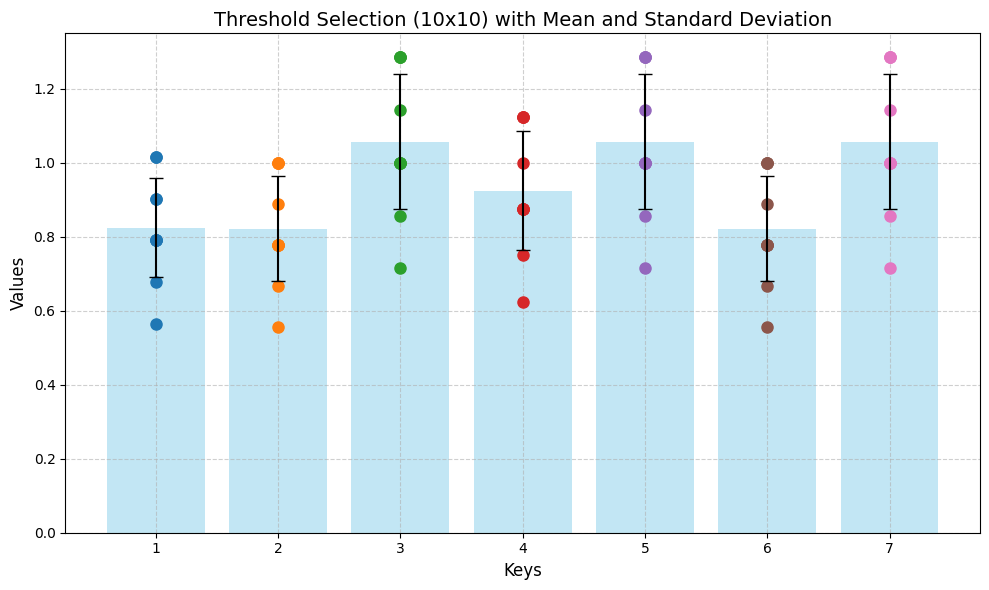

Model Metrics:
3 - Mean: 1.06, Std Dev: 0.1829, 95%: 0.69
5 - Mean: 1.06, Std Dev: 0.1829, 95%: 0.69
7 - Mean: 1.06, Std Dev: 0.1829, 95%: 0.69
4 - Mean: 0.93, Std Dev: 0.1601, 95%: 0.60
1 - Mean: 0.82, Std Dev: 0.1341, 95%: 0.56
2 - Mean: 0.82, Std Dev: 0.1423, 95%: 0.54
6 - Mean: 0.82, Std Dev: 0.1423, 95%: 0.54


In [31]:
# self.board.count("_") >= threshold

results = [[0.8, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7, 0.6], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7, 0.6], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7, 0.6], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7, 0.6], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7, 0.6], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7, 0.6], [0.9, 0.9, 0.7, 0.8, 0.7, 0.9, 0.7, 0.5, 0.7, 0.6]]

iter_mean_perf = []
for vs in zip(*results):
    iter_mean_perf.append(np.mean(vs))

results = {k+1: results[k] / iter_mean_perf[k] for k in range(7)}

fig, ax = plt.subplots(figsize=(10, 6))

keys = list(results.keys())
means = [np.mean(results[key]) for key in keys]
std_devs = [np.std(results[key]) for key in keys]

for key in keys:
    ax.plot([key] * len(results[key]), results[key], 'o', label=f'{key} values', markersize=8)

ax.bar(keys, means, yerr=std_devs, capsize=5, color='skyblue', alpha=0.5, label='Mean with Std Dev')

ax.set_xlabel('Keys', fontsize=12)
ax.set_ylabel('Values', fontsize=12)
ax.set_title('Threshold Selection (10x10) with Mean and Standard Deviation', fontsize=14)

ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

print("Model Metrics:")

metrics = {k:(means[i], std_devs[i]) for i, k in enumerate(results.keys())}
metrics = dict(sorted(metrics.items(), key=lambda x: (-x[1][0], x[1][1])))

for threshold, (mean_val, std) in metrics.items():
    print(f"{threshold} - Mean: {mean_val:.2f}, Std Dev: {std:.4f}, 95%: {mean_val - 2 * std:.2f}")